In [1]:
import rmtchem 
import timeit
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from scipy.integrate import solve_bvp
from scipy.signal import argrelmax,find_peaks
import importlib as imp
import cantera as ct
import os
imp.reload(rmtchem)
from scipy.sparse import csr_matrix
import warnings
warnings.simplefilter("ignore")

plt.rcParams.update({'font.size': 12, 'pdf.fonttype':42,'text.usetex': False, 'font.family': 'serif'})
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

### Pseudoarclength continuation

128 310 12 0 1549
1	3	
1	3	1	3	
459	309	
126 123
6.13141e+01	2.60123e-04	-1.29368e-01	2.52877e-03	717	1	7.42166e-12	
Saddle-node bifurcation!	61.314122
3.91252e+01	8.77915e-04	1.39839e-01	-2.92415e-03	1133	1	7.80972e-11		
Saddle-node bifurcation!	39.125164
1.00004e+02	7.59375e-02	9.90493e-01	7.66572e-02	1998	1	1.25977e-13	
 50.8095871810001


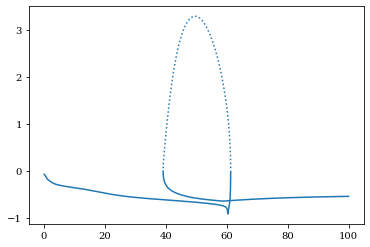

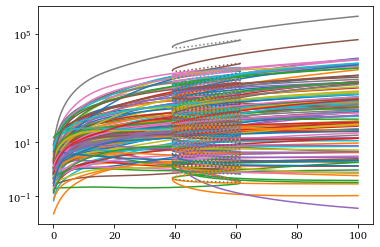

In [3]:
imp.reload(rmtchem)
n=128
nr=int(0.5*n*np.log(n))
nd=int(0.1*n)
na=int(0.0*nr)
seed=1115 #isola at 35
seed=2398 #chaotic at 75
seed=1549
natoms=3

print(n,nr,nd,na,seed)

np.random.seed(seed)
eta,nu,k,G,atoms=rmtchem.get_network(n,nr,na,natoms,True) 
row,col=np.where(eta[::2]-nu[::2]!=0)
data=(eta[::2]-nu[::2])[row,col]
A=csr_matrix((data,(row,col)),shape=(2*nr,n),dtype=int)
adj=A.T.dot(A)
g=nx.convert_matrix.from_scipy_sparse_array(adj)
lcc=np.array(list(max(nx.connected_components(g), key=len)))
n=len(lcc)
eta=eta[:,lcc]
nu=nu[:,lcc]
G=G[lcc]
d0=1e6
d1min=0
d1max=100
XD1,XD2,inds=rmtchem.get_drive(eta,nu,k,G,d0,nd)
m=(eta[::2]-nu[::2]).T.dot(nu[::2]-eta[::2])
print(len(lcc),np.linalg.matrix_rank(m))

X0=np.exp(-G)
start=timeit.default_timer()
Xs,epsilons,evals,bif,dxs=rmtchem.pseudoarclength_log(X0, eta, nu, k, XD1, XD2, 0, 100, ds=1e-2,  dsmax=10e-2, output=2,stop=False,sn_detect=False,hopf_detect=False,cond_detect=False)

stop=timeit.default_timer()
print('\n',stop-start)
plt.figure()
inds1=np.where(np.max(np.real(evals),axis=1)<0)[0]
inds2=np.where(np.max(np.real(evals),axis=1)>=0)[0]

for inds in np.split(inds1, np.where(np.diff(inds1) != 1)[0]+1):
    plt.plot(epsilons[inds],np.max(np.real(evals),axis=1)[inds],ls='-',color=colors[0])
for inds in np.split(inds2, np.where(np.diff(inds2) != 1)[0]+1):
    plt.plot(epsilons[inds],np.max(np.real(evals),axis=1)[inds],ls=':',color=colors[0])
plt.show()

plt.figure()
inds1=np.where(np.max(np.real(evals),axis=1)<0)[0]
inds2=np.where(np.max(np.real(evals),axis=1)>=0)[0]
plt.yscale('log')
for inds in np.split(inds1, np.where(np.diff(inds1) != 1)[0]+1):
    for i in range(n):
        plt.plot(epsilons[inds],Xs[inds,i],color=colors[np.mod(i,len(colors))])
for inds in np.split(inds2, np.where(np.diff(inds2) != 1)[0]+1):
    for i in range(n):
        plt.plot(epsilons[inds],Xs[inds,i],ls=':',color=colors[np.mod(i,len(colors))])

40.00415112384076 10.963500757525747
0.000097	0.000000	289959	2	lsoda	Unexpected istate in LSODA.
keyboard
2924.458413640008


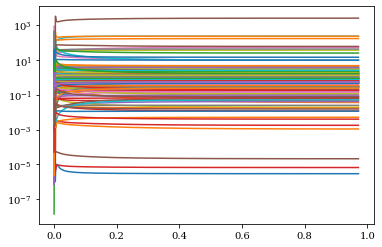

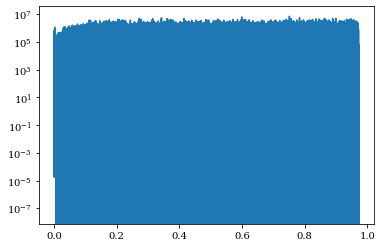

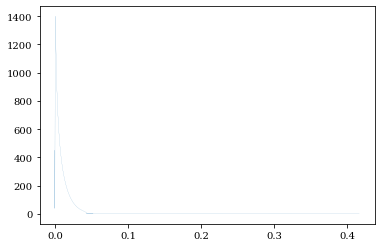

248621.5075366806 27.164976333665027


In [71]:
imp.reload(rmtchem)

null_fd = os.open(os.devnull, os.O_RDWR)
os.dup2(null_fd, 1) #trick to suppress stdout from lsoda fortran calls

# m0=np.where(np.max(np.real(evals),axis=1)>0)[0][0]
epsilon0=40
m0=np.argmin(np.abs(epsilons-epsilon0))
X0=Xs[m0]
# X0=Xs[m0]*10*np.random.random(size=n)
np.random.seed(1)
X0=np.random.random(size=n)
epsilon=35
ev,evec=np.linalg.eig(rmtchem.jac(0,X0,eta,nu,k,(1+epsilon)*XD1, XD2))
tscale=2*np.pi/np.abs(np.real(ev[np.argmin(np.abs(np.real(ev)))]))
dt=100/np.max(np.abs(rmtchem.func(0,X0,eta,nu,k,(1+epsilon)*XD1, XD2)/X0))
print(epsilons[m0],np.max(np.real(evals[m0])))

start=timeit.default_timer()
ts,Xts,success,m1,state=rmtchem.integrate(X0,eta,nu,k,(1+epsilon)*XD1,XD2,1e4*tscale,dt,output=True,maxcycles=25)
stop=timeit.default_timer()
print(stop-start,flush=True)

plt.yscale('log')
plt.plot(ts/tscale,np.transpose(Xts)/Xs[m0])
plt.show()
plt.yscale('log')
plt.plot(ts[:-1]/tscale,np.diff(ts)/dt)
plt.show()
plt.plot(Xts[0,m1:],Xts[1,m1:],linewidth=0.1)
plt.show()

mind=np.argmin(np.linalg.norm((Xs-Xts[:,-1])/Xts[:,-1],axis=1))
print(np.linalg.norm((Xs-Xts[:,-1])/Xts[:,-1],axis=1)[mind],epsilons[mind])

0.000037	0.000000	81647	0	lsoda	Unexpected istate in LSODA.
Found steady state!
376.42948699899716


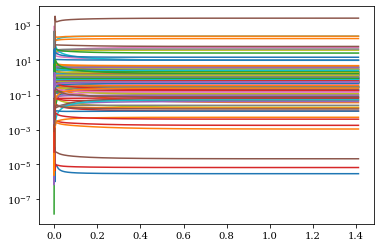

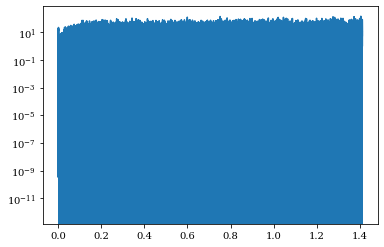

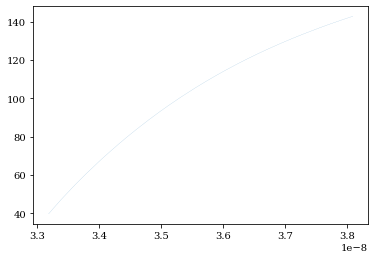

248759.49611240375 27.164976333665027


In [84]:
imp.reload(rmtchem)
start=timeit.default_timer()
dt=np.mean(np.diff(ts)[-10])
ts2,Xts2,success,m1,state=rmtchem.integrate(Xts[:,-1],eta,nu,k,(1+epsilon)*XD1,XD2,1e4*tscale,dt,output=True,maxcycles=25)
stop=timeit.default_timer()
print(stop-start)

ts=np.concatenate([ts,ts[-1]+ts2])
Xts=np.concatenate([Xts,Xts2],axis=1)
plt.yscale('log')
plt.plot(ts/tscale,np.transpose(Xts)/Xs[m0])
plt.show()
plt.yscale('log')
plt.plot(ts[:-1]/tscale,np.diff(ts)/dt)
plt.show()
plt.plot(Xts[0,m1:],Xts[1,m1:],linewidth=0.1)
plt.show()

mind=np.argmin(np.linalg.norm((Xs-Xts[:,-1])/Xts[:,-1],axis=1))
print(np.linalg.norm((Xs-Xts[:,-1])/Xts[:,-1],axis=1)[mind],epsilons[mind])

### Saddle-node bifurcations

128 310 12 0 1549
1	3	
1	3	1	3	
459	309	
126 123
6.13141e+01	2.60123e-04	-1.29368e-01	2.52877e-03	717	1	7.42166e-12	
Saddle-node bifurcation!	61.320109
3.91252e+01	8.77915e-04	1.39839e-01	-2.92415e-03	1133	1	7.80972e-11		
Saddle-node bifurcation!	39.107072


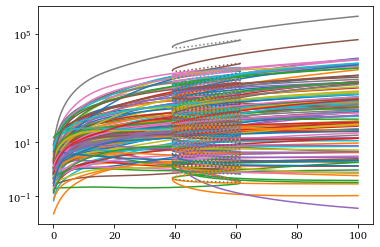

In [6]:
n=128
nr=int(0.5*n*np.log(n))
nd=int(0.1*n)
na=int(0.0*nr)
seed=1549
natoms=3
print(n,nr,nd,na,seed)

np.random.seed(seed)
eta,nu,k,G,atoms=rmtchem.get_network(n,nr,na,natoms,True) 
row,col=np.where(eta[::2]-nu[::2]!=0)
data=(eta[::2]-nu[::2])[row,col]
A=csr_matrix((data,(row,col)),shape=(2*nr,n),dtype=int)
adj=A.T.dot(A)
g=nx.convert_matrix.from_scipy_sparse_matrix(adj)
lcc=np.array(list(max(nx.connected_components(g), key=len)))
n=len(lcc)
eta=eta[:,lcc]
nu=nu[:,lcc]
G=G[lcc]
d0=1e6
d1min=0
d1max=100
XD1,XD2,inds=rmtchem.get_drive(eta,nu,k,G,d0,nd)
m=(eta[::2]-nu[::2]).T.dot(nu[::2]-eta[::2])
print(len(lcc),np.linalg.matrix_rank(m))

X0=np.exp(-G)
start=timeit.default_timer()
Xs,epsilons,evals,bif,dxs=rmtchem.pseudoarclength_log(X0, eta, nu, k, XD1, XD2, 0, 100, ds=1e-2,  dsmax=10e-2, output=2,stop=False,cond_detect=False)

plt.figure()
inds1=np.where(np.max(np.real(evals),axis=1)<0)[0]
inds2=np.where(np.max(np.real(evals),axis=1)>=0)[0]
plt.yscale('log')
for inds in np.split(inds1, np.where(np.diff(inds1) != 1)[0]+1):
    for i in range(n):
        plt.plot(epsilons[inds],Xs[inds,i],color=colors[np.mod(i,len(colors))])
for inds in np.split(inds2, np.where(np.diff(inds2) != 1)[0]+1):
    for i in range(n):
        plt.plot(epsilons[inds],Xs[inds,i],ls=':',color=colors[np.mod(i,len(colors))])

In [7]:
np.save('data/sn/Xs.npy',Xs)
np.save('data/sn/epsilons.npy',epsilons)
np.save('data/sn/evals.npy',evals)

### Hopf bifurcations

128 310 12 0 1348
1	3	
1	3	1	3	
429	309	
126 123
5.15732e+01	7.59375e-02	8.37937e-01	8.98881e-02	525	1	1.00538e-12	
Supercritical Hopf bifurcation!	51.573225


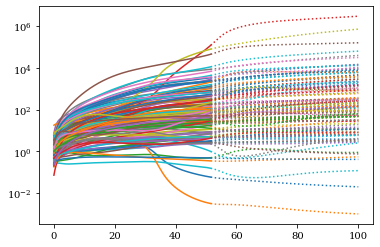

In [34]:
n=128
nr=int(0.5*n*np.log(n))
nd=int(0.1*n)
na=int(0.0*nr)
seed=1348
natoms=3
print(n,nr,nd,na,seed)

np.random.seed(seed)
eta,nu,k,G,atoms=rmtchem.get_network(n,nr,na,natoms,True) 
row,col=np.where(eta[::2]-nu[::2]!=0)
data=(eta[::2]-nu[::2])[row,col]
A=csr_matrix((data,(row,col)),shape=(2*nr,n),dtype=int)
adj=A.T.dot(A)
g=nx.convert_matrix.from_scipy_sparse_matrix(adj)
lcc=np.array(list(max(nx.connected_components(g), key=len)))
n=len(lcc)
eta=eta[:,lcc]
nu=nu[:,lcc]
G=G[lcc]
d0=1e6
d1min=0
d1max=100
XD1,XD2,inds=rmtchem.get_drive(eta,nu,k,G,d0,nd)
m=(eta[::2]-nu[::2]).T.dot(nu[::2]-eta[::2])
print(len(lcc),np.linalg.matrix_rank(m))

X0=np.exp(-G)
start=timeit.default_timer()
Xs,epsilons,evals,bif,dxs=rmtchem.pseudoarclength_log(X0, eta, nu, k, XD1, XD2, 0, 100, ds=1e-2,  dsmax=10e-2, output=2,stop=False,cond_detect=False)

plt.figure()
inds1=np.where(np.max(np.real(evals),axis=1)<0)[0]
inds2=np.where(np.max(np.real(evals),axis=1)>=0)[0]
plt.yscale('log')
for inds in np.split(inds1, np.where(np.diff(inds1) != 1)[0]+1):
    for i in range(n):
        plt.plot(epsilons[inds],Xs[inds,i],color=colors[np.mod(i,len(colors))])
for inds in np.split(inds2, np.where(np.diff(inds2) != 1)[0]+1):
    for i in range(n):
        plt.plot(epsilons[inds],Xs[inds,i],ls=':',color=colors[np.mod(i,len(colors))])

52.49732884855038 400.67791382612836 0.5181878863386851
0.000023	0.000000	8028	25	lsoda	Unexpected istate in LSODA.
Found oscillating state!
True 16.01657063699895


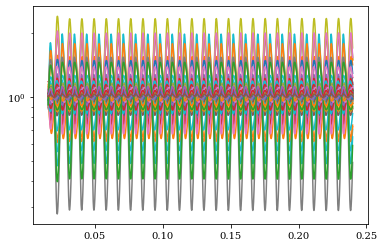

341 8321


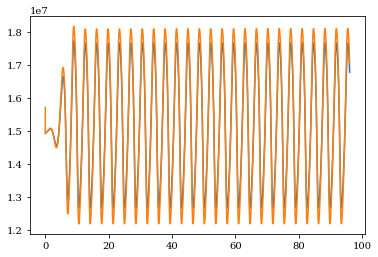

14931163.80361639 15232812.49573148 14931163.803618977 15234462.917286286 1.4849847502429536 21113.173452195995


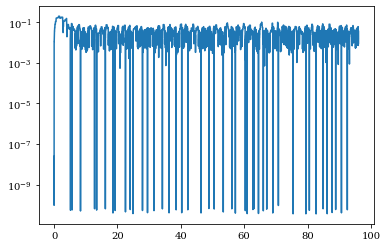

1


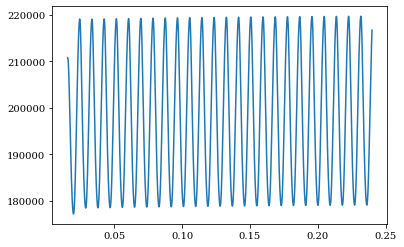

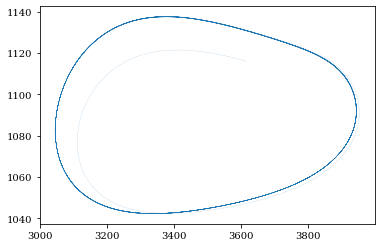

In [40]:
imp.reload(rmtchem)

null_fd = os.open(os.devnull, os.O_RDWR)
os.dup2(null_fd, 1) #trick to suppress stdout from lsoda fortran calls

m0=np.where(np.max(np.real(evals),axis=1)>0)[0][0]+10
X0=Xs[m0]
sd1=rmtchem.Sdot(rmtchem.rates(X0,eta,nu,k))
wd1=rmtchem.Wdot(X0, G, (1+epsilons[m0])*XD1, XD2)
epsilon=epsilons[m0]+1e-2
ev,evec=np.linalg.eig(rmtchem.jac(0,X0,eta,nu,k,(1+epsilon)*XD1, XD2))
tscale=2*np.pi/np.abs(np.real(ev[np.argmin(np.abs(np.real(ev)))]))
dt=100/np.max(np.abs(rmtchem.func(0,X0,eta,nu,k,(1+epsilon)*XD1, XD2)/X0))
print(epsilon,tscale,dt)

start=timeit.default_timer()
ts,Xts,success,m0,state=rmtchem.integrate(X0,eta,nu,k,(1+epsilon)*XD1,XD2,1e4*tscale,dt,output=True,maxcycles=25,maxsteps=1e4)
# m0=int(m0+9*(len(ts)-m0)/10)
stop=timeit.default_timer()
print(success,stop-start)

plt.yscale('log')
plt.plot(ts[m0:]/tscale,np.transpose(Xts)[m0:]/X0)
plt.show()

sd=[rmtchem.Sdot(rmtchem.rates(Xts[:,i],eta,nu,k)) for i in range(len(ts))]
wd=[rmtchem.Wdot(Xts[:,i],G,(1+epsilon)*XD1,XD2) for i in range(len(ts))]
print(m0,len(ts))
sd2=np.sum(np.diff(ts)[m0-1:]*sd[m0:])/np.sum(np.diff(ts)[m0-1:])
wd2=np.sum(np.diff(ts)[m0-1:]*wd[m0:])/ np.sum(np.diff(ts)[m0-1:])
dn1=np.sum(np.diff(ts)[m0-1:]*[np.linalg.norm((Xts[:,i]-X0)/X0) for i in range(m0,len(ts))])/ np.sum(np.diff(ts)[m0-1:])
dn2=np.sum(np.diff(ts)[m0-1:]*[np.linalg.norm(Xts[:,i]-X0) for i in range(m0,len(ts))])/ np.sum(np.diff(ts)[m0-1:])
plt.plot(ts,sd)
plt.plot(ts,wd)
plt.show()
print(sd1, sd2, wd1, wd2, dn1,dn2)

plt.yscale('log')
plt.plot(ts[:-1],np.diff(ts)/dt)
plt.show()
print(state)
plt.plot(ts[m0:]/tscale,np.linalg.norm(Xts,axis=0)[m0:])
plt.show()
plt.plot(Xts[0,m0:],Xts[1,m0:],linewidth=0.1)
plt.show()


In [41]:
np.save('data/hopf/Xs.npy',Xs)
np.save('data/hopf/epsilons.npy',epsilons)
np.save('data/hopf/evals.npy',evals)
np.save('data/hopf/ts.npy',ts)
np.save('data/hopf/Xts.npy',Xts)

### Chaos

128 310 12 155 2398
1	3	
1	3	1	3	
429	309	


/tmp/ipykernel_21273/727232173.py:17: DeprecationWarning: 

The scipy.sparse array containers will be used instead of matrices
in Networkx 3.0. Use `from_scipy_sparse_array` instead.
  g=nx.convert_matrix.from_scipy_sparse_matrix(adj)


4.79819e+01	9.85261e-02	9.05805e-01	1.08470e-01	508	1	2.97415e-14	
Subcritical Hopf bifurcation!	47.981935
7.93459e+01	9.85261e-02	9.77208e-01	1.00813e-01	803	1	1.14001e-16	
Supercritical Hopf bifurcation!	79.345925


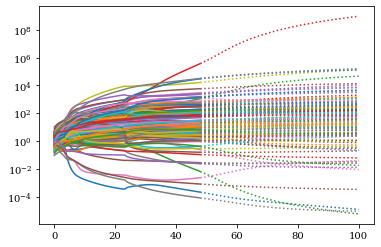

In [2]:
n=128
nr=int(0.5*n*np.log(n))
nd=int(0.1*n)
na=int(0.5*nr)
seed=1115 #isola at 40
seed=2398 #chaotic at 75
natoms=3

print(n,nr,nd,na,seed)

np.random.seed(seed)
eta,nu,k,G,atoms=rmtchem.get_network(n,nr,na,natoms,True) 
row,col=np.where(eta[::2]-nu[::2]!=0)
data=(eta[::2]-nu[::2])[row,col]
A=csr_matrix((data,(row,col)),shape=(2*nr,n),dtype=int)
adj=A.T.dot(A)
g=nx.convert_matrix.from_scipy_sparse_matrix(adj)
lcc=np.array(list(max(nx.connected_components(g), key=len)))
n=len(lcc)
eta=eta[:,lcc]
nu=nu[:,lcc]
G=G[lcc]
d0=1e6
d1min=0
d1max=100
XD1,XD2,inds=rmtchem.get_drive(eta,nu,k,G,d0,nd)
X0=np.exp(-G)
start=timeit.default_timer()

Xs,epsilons,evals,bif,dxs=rmtchem.pseudoarclength_log(X0, eta, nu, k, XD1, XD2, d1min,d1max,ds=1e-4, dsmax=1e-1,output=2,stop=False,cond_detect=False)

plt.figure()
inds1=np.where(np.max(np.real(evals),axis=1)<0)[0]
inds2=np.where(np.max(np.real(evals),axis=1)>=0)[0]
plt.yscale('log')
for inds in np.split(inds1, np.where(np.diff(inds1) != 1)[0]+1):
    for i in range(n):
        plt.plot(epsilons[inds],Xs[inds,i],color=colors[np.mod(i,len(colors))])
for inds in np.split(inds2, np.where(np.diff(inds2) != 1)[0]+1):
    for i in range(n):
        plt.plot(epsilons[inds],Xs[inds,i],ls=':',color=colors[np.mod(i,len(colors))])

74.99761107689179 36.3771905291276
0.000000	0.000000	99989	0	lsoda	Unexpected istate in LSODA.
Failed to find state in maxsteps! 100074
196.23720355299884


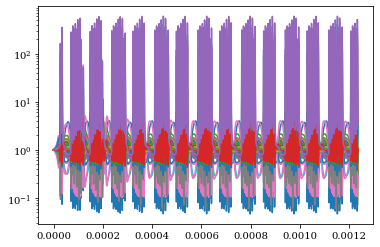

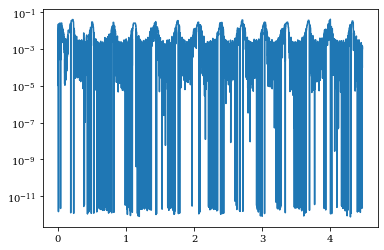

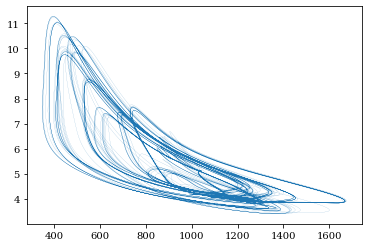

In [3]:
imp.reload(rmtchem)

null_fd = os.open(os.devnull, os.O_RDWR)
os.dup2(null_fd, 1) #trick to suppress stdout from lsoda fortran calls

m0=np.where(np.max(np.real(evals),axis=1)>0)[0][0]
epsilon0=75
m0=np.argmin(np.abs(epsilons-epsilon0))
X0=Xs[m0]
sd1=rmtchem.Sdot(rmtchem.rates(X0,eta,nu,k))
wd1=rmtchem.Wdot(X0, G, (1+epsilons[m0])*XD1, XD2)
epsilon=epsilons[m0]+1e-1
ev,evec=np.linalg.eig(rmtchem.jac(0,X0,eta,nu,k,(1+epsilon)*XD1, XD2))
tscale=2*np.pi/np.abs(np.real(ev[np.argmin(np.abs(np.real(ev)))]))
dt=100/np.max(np.abs(rmtchem.func(0,X0,eta,nu,k,(1+epsilon)*XD1, XD2)/X0))
print(epsilons[m0],np.max(np.real(evals[m0])))

start=timeit.default_timer()
ts,Xts,success,m1,state=rmtchem.integrate(X0,eta,nu,k,(1+epsilon)*XD1,XD2,1e4*tscale,dt,output=True,maxcycles=25,maxsteps=1e5)
stop=timeit.default_timer()
print(stop-start)

plt.yscale('log')
plt.plot(ts/tscale,np.transpose(Xts)/X0)
plt.show()
plt.yscale('log')
plt.plot(ts[:-1],np.diff(ts)/dt)
plt.show()
plt.plot(Xts[0,m1:],Xts[1,m1:],linewidth=0.1)
plt.show()


In [4]:
if not os.path.exists('data/chaos'):
    os.mkdir('data/chaos')
np.save('data/chaos/Xs.npy',Xs)
np.save('data/chaos/epsilons.npy',epsilons)
np.save('data/chaos/evals.npy',evals)
np.save('data/chaos/ts.npy',ts)
np.save('data/chaos/Xts.npy',Xts)

### Isola 

128 310 12 155 1115
1	3	
1	3	1	3	
457	309	
1.28669e+01	9.85261e-02	5.51772e-01	1.77626e-01	212	1	7.01517e-14	
Supercritical Hopf bifurcation!	12.866864
7.76001e+01	9.85261e-02	9.69088e-01	1.01656e-01	749	3	3.12262e-18	
Supercritical Hopf bifurcation!	77.600109


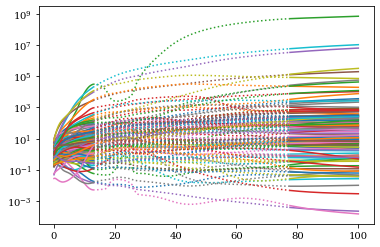

In [5]:
n=128
nr=int(0.5*n*np.log(n))
nd=int(0.1*n)
na=int(0.5*nr)
seed=1115 #isola at 40
natoms=3

print(n,nr,nd,na,seed)

np.random.seed(seed)
eta,nu,k,G,atoms=rmtchem.get_network(n,nr,na,natoms,True) 
row,col=np.where(eta[::2]-nu[::2]!=0)
data=(eta[::2]-nu[::2])[row,col]
A=csr_matrix((data,(row,col)),shape=(2*nr,n),dtype=int)
adj=A.T.dot(A)
g=nx.convert_matrix.from_scipy_sparse_matrix(adj)
lcc=np.array(list(max(nx.connected_components(g), key=len)))
n=len(lcc)
eta=eta[:,lcc]
nu=nu[:,lcc]
G=G[lcc]
d0=1e6
d1min=0
d1max=100
XD1,XD2,inds=rmtchem.get_drive(eta,nu,k,G,d0,nd)
X0=np.exp(-G)
start=timeit.default_timer()

Xs,epsilons,evals,bif,dxs=rmtchem.pseudoarclength_log(X0, eta, nu, k, XD1, XD2, d1min,d1max,ds=1e-4, dsmax=1e-1,output=2,stop=False,cond_detect=False)

plt.figure()
inds1=np.where(np.max(np.real(evals),axis=1)<0)[0]
inds2=np.where(np.max(np.real(evals),axis=1)>=0)[0]
plt.yscale('log')
for inds in np.split(inds1, np.where(np.diff(inds1) != 1)[0]+1):
    for i in range(n):
        plt.plot(epsilons[inds],Xs[inds,i],color=colors[np.mod(i,len(colors))])
for inds in np.split(inds2, np.where(np.diff(inds2) != 1)[0]+1):
    for i in range(n):
        plt.plot(epsilons[inds],Xs[inds,i],ls=':',color=colors[np.mod(i,len(colors))])

78.7167472579842 -0.003944290917744269
0.000141	0.000000	384538	2	lsoda	Unexpected istate in LSODA.
Found steady state!
5938.203743713006


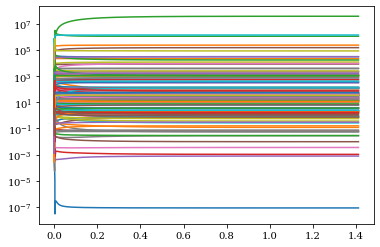

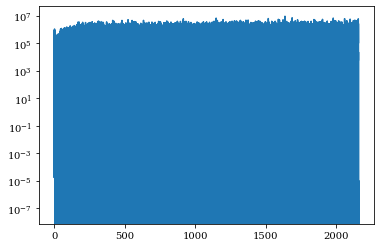

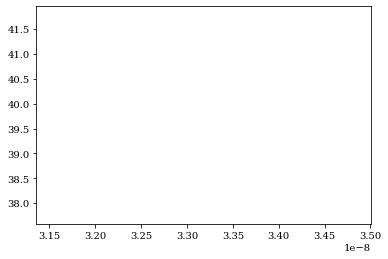

In [8]:
imp.reload(rmtchem)

null_fd = os.open(os.devnull, os.O_RDWR)
os.dup2(null_fd, 1) #trick to suppress stdout from lsoda fortran calls

np.random.seed(1)
X0=np.random.random(size=n)
epsilon=35
ev,evec=np.linalg.eig(rmtchem.jac(0,X0,eta,nu,k,(1+epsilon)*XD1, XD2))
tscale=2*np.pi/np.abs(np.real(ev[np.argmin(np.abs(np.real(ev)))]))
dt=100/np.max(np.abs(rmtchem.func(0,X0,eta,nu,k,(1+epsilon)*XD1, XD2)/X0))
print(epsilons[m0],np.max(np.real(evals[m0])))

start=timeit.default_timer()
ts,Xts,success,m1,state=rmtchem.integrate(X0,eta,nu,k,(1+epsilon)*XD1,XD2,1e4*tscale,dt,output=True,maxcycles=25)
stop=timeit.default_timer()
print(stop-start)

plt.yscale('log')
plt.plot(ts/tscale,np.transpose(Xts)/X0)
plt.show()
plt.yscale('log')
plt.plot(ts[:-1],np.diff(ts)/dt)
plt.show()
plt.plot(Xts[0,m1:],Xts[1,m1:],linewidth=0.1)
plt.show()


4.19288e+01	3.90184e-04	1.28209e-04	7.51665e-02	40	2	8.24622e-19	
Subcritical Hopf bifurcation!	41.928840
4.18741e+01	3.90184e-04	-1.79316e-02	1.84189e-02	41	2	1.40782e-17	
Saddle-node bifurcation!	41.874117
2.32875e+01	6.66667e-03	2.32267e-01	-3.46367e-02	340	1	2.41109e-15		
Saddle-node bifurcation!	23.287522
4.19264e+01	8.77915e-04	-6.48636e-02	1.27560e-02	590	2	1.17676e-17	
Saddle-node bifurcation!	41.926410
3.99721e+01	5.06250e-02	-8.37751e-01	-6.05883e-02	705	2	7.30751e-17	
Keyboard interrupt

 22.611714868005947


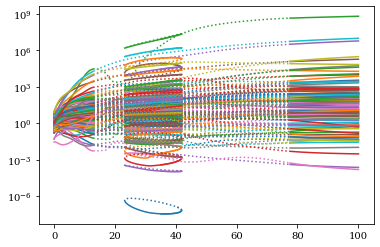

In [9]:
start=timeit.default_timer()
Xs2,epsilons2,evals2,bif2,dxs2=rmtchem.pseudoarclength_log(Xts[:,-1], eta, nu, k, XD1, XD2, epsilon, 100, ds=1e-2,  dsmax=10e-2, output=2,stop=False,sn_detect=False,hopf_detect=True,cond_detect=False)
stop=timeit.default_timer()

print('\n',stop-start)

plt.figure()
inds1=np.where(np.max(np.real(evals),axis=1)<0)[0]
inds2=np.where(np.max(np.real(evals),axis=1)>=0)[0]
plt.yscale('log')
for inds in np.split(inds1, np.where(np.diff(inds1) != 1)[0]+1):
    for i in range(n):
        plt.plot(epsilons[inds],Xs[inds,i],color=colors[np.mod(i,len(colors))])
for inds in np.split(inds2, np.where(np.diff(inds2) != 1)[0]+1):
    for i in range(n):
        plt.plot(epsilons[inds],Xs[inds,i],ls=':',color=colors[np.mod(i,len(colors))])
        
inds1=np.where(np.max(np.real(evals2),axis=1)<0)[0]
inds2=np.where(np.max(np.real(evals2),axis=1)>=0)[0]
plt.yscale('log')
for inds in np.split(inds1, np.where(np.diff(inds1) != 1)[0]+1):
    for i in range(n):
        plt.plot(epsilons2[inds],Xs2[inds,i],color=colors[np.mod(i,len(colors))])
for inds in np.split(inds2, np.where(np.diff(inds2) != 1)[0]+1):
    for i in range(n):
        plt.plot(epsilons2[inds],Xs2[inds,i],ls=':',color=colors[np.mod(i,len(colors))])        

In [11]:
if not os.path.exists('data/isola'):
    os.mkdir('data/isola')
np.save('data/isola/Xs.npy',Xs)
np.save('data/isola/epsilons.npy',epsilons)
np.save('data/isola/evals.npy',evals)
np.save('data/isola/Xs2.npy',Xs2)
np.save('data/isola/epsilons2.npy',epsilons2)
np.save('data/isola/evals2.npy',evals2)
np.save('data/isola/Xts.npy',Xts)
np.save('data/isola/ts.npy',ts)

### Snaking 

128 310 12 155 2341
1	3	
1	3	1	3	
391	309	
2.26101e+01	9.85261e-02	4.17822e-01	1.44825e-01	298	1	5.40327e-13	
Hopf bifurcation!	22.610148
2.28161e+01	8.64976e-03	-7.02511e-02	3.19588e-02	307	1	9.30561e-13	
Saddle-node bifurcation!	22.816097
2.05296e+01	2.56289e-03	1.60686e-01	-1.63659e-02	363	1	9.51036e-14		
Saddle-node bifurcation!	20.529631
8.88005e+01	6.66667e-05	-1.62124e-01	8.90003e-04	1107	1	2.19161e-15	
Saddle-node bifurcation!	88.800497
3.23906e+01	1.13906e-03	1.43962e-01	-1.78687e-03	1837	1	1.08732e-14		
Saddle-node bifurcation!	32.390602
9.50065e+01	9.85261e-02	9.93586e-01	9.91453e-02	2548	1	6.17107e-15	
Hopf bifurcation!	95.006471
9.79784e+01	2.96296e-05	-1.24673e-01	4.09321e-04	2602	1	1.81646e-15	
Saddle-node bifurcation!	97.978428
3.60340e+01	1.70859e-03	1.59585e-01	-6.36771e-03	3422	1	2.22773e-14		
Saddle-node bifurcation!	36.034046
3.62242e+01	3.84434e-03	1.39761e-01	8.02253e-03	3443	1	6.28997e-15	
Hopf bifurcation!	36.224204


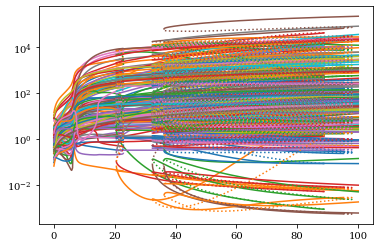

In [13]:
n=128
nr=int(0.5*n*np.log(n))
nd=int(0.1*n)
na=int(0.5*nr)
seed=2341 
natoms=3

print(n,nr,nd,na,seed)

np.random.seed(seed)
eta,nu,k,G,atoms=rmtchem.get_network(n,nr,na,natoms,True) 
row,col=np.where(eta[::2]-nu[::2]!=0)
data=(eta[::2]-nu[::2])[row,col]
A=csr_matrix((data,(row,col)),shape=(2*nr,n),dtype=int)
adj=A.T.dot(A)
g=nx.convert_matrix.from_scipy_sparse_matrix(adj)
lcc=np.array(list(max(nx.connected_components(g), key=len)))
n=len(lcc)
eta=eta[:,lcc]
nu=nu[:,lcc]
G=G[lcc]
d0=1e6
d1min=0
d1max=100
XD1,XD2,inds=rmtchem.get_drive(eta,nu,k,G,d0,nd)
X0=np.exp(-G)
start=timeit.default_timer()

Xs,epsilons,evals,bif,dxs=rmtchem.pseudoarclength_log(X0, eta, nu, k, XD1, XD2, d1min,d1max,ds=1e-4, dsmax=1e-1,output=2,stop=False, sn_detect=False,cond_detect=False,hopf_detect=False)

plt.figure()
inds1=np.where(np.max(np.real(evals),axis=1)<0)[0]
inds2=np.where(np.max(np.real(evals),axis=1)>=0)[0]
plt.yscale('log')
for inds in np.split(inds1, np.where(np.diff(inds1) != 1)[0]+1):
    for i in range(n):
        plt.plot(epsilons[inds],Xs[inds,i],color=colors[np.mod(i,len(colors))])
for inds in np.split(inds2, np.where(np.diff(inds2) != 1)[0]+1):
    for i in range(n):
        plt.plot(epsilons[inds],Xs[inds,i],ls=':',color=colors[np.mod(i,len(colors))])

In [22]:
if not os.path.exists('data/snaking'):
    os.mkdir('data/snaking')
np.save('data/snaking/Xs.npy',Xs)
np.save('data/snaking/epsilons.npy',epsilons)
np.save('data/snaking/evals.npy',evals)

### sweep of seeds

128 310 12 155 1013
128 125

Failed to converge!	18.372260	0.000000	0.000000

 10.224259495997103


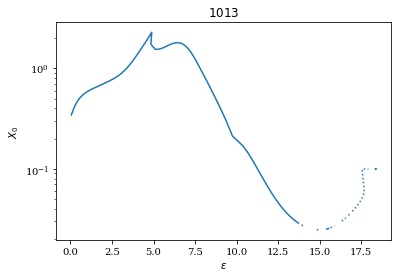

59.615
128 310 12 155 1017
126 123

 40.23297739299596


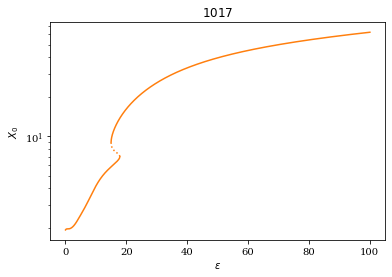

128 310 12 155 1022
128 125

 41.50734170500073


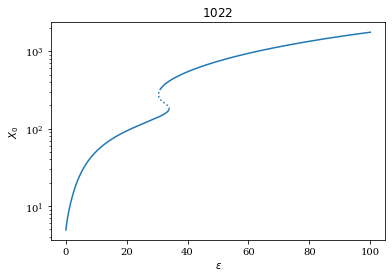

128 310 12 155 1029
128 125

 44.45305334898876


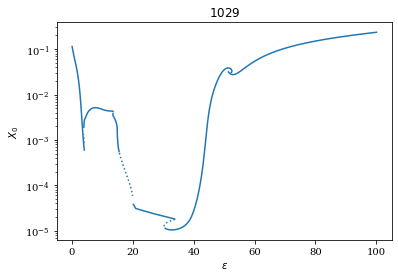

17.849999999999998
128 310 12 155 1030
127 124

Failed to converge!	52.574995	-0.853549	0.000000

 24.245113120006863


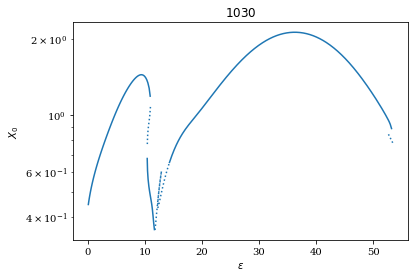

76.22543201896143
128 310 12 155 1031
128 125

 31.115481512999395


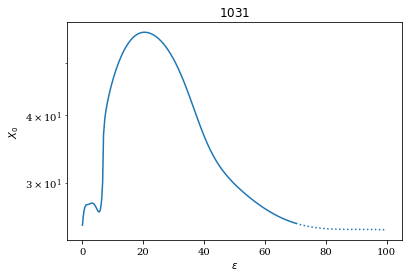

85.535
128 310 12 155 1033
128 125

 52.71728872298263


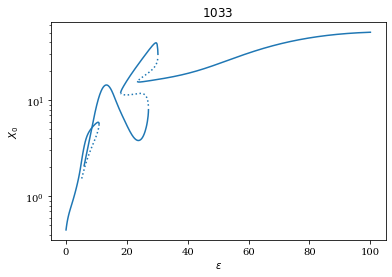

128 310 12 155 1035
127 124

 38.351854689011816


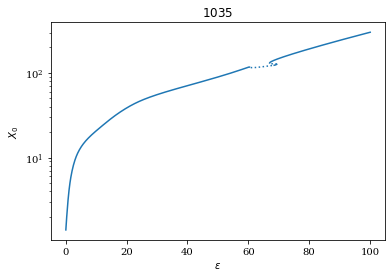

63.695
128 310 12 155 1046
128 125

 109.73320271199918


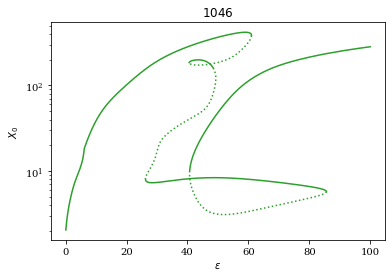

128 310 12 155 1047
127 124

 37.52470034302678


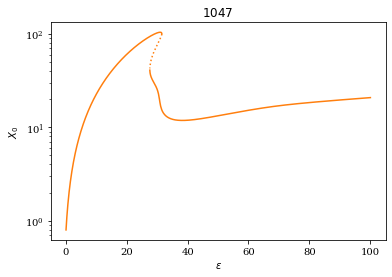

128 310 12 155 1048
128 125

 30.891891432984266


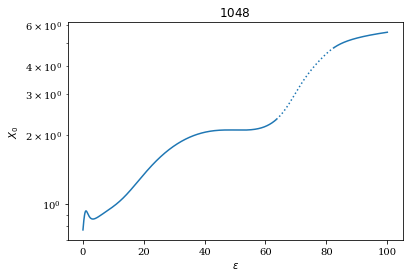

73.075
128 310 12 155 104
127 124

 40.95919276101631


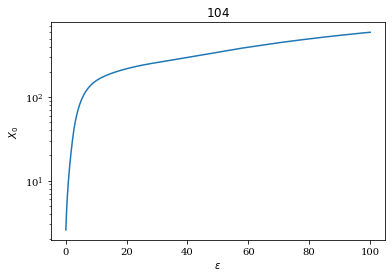

128 310 12 155 1059
126 123

 32.37254791299347


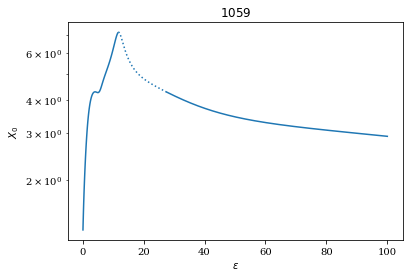

19.555
128 310 12 155 1064
127 124

 40.285373635008


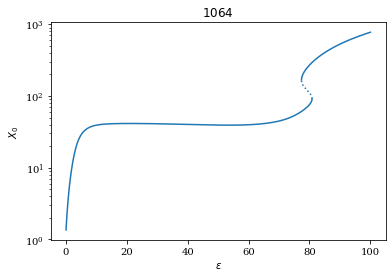

128 310 12 155 1068
128 125

 40.96386928099673


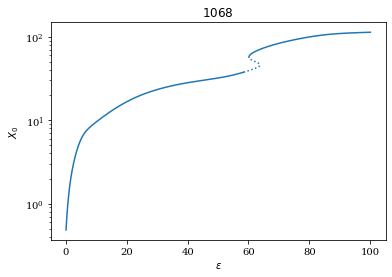

128 310 12 155 1087
126 123

 47.484320363000734


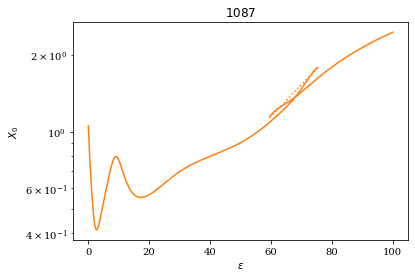

128 310 12 155 1115
126 123

 29.372711603995413


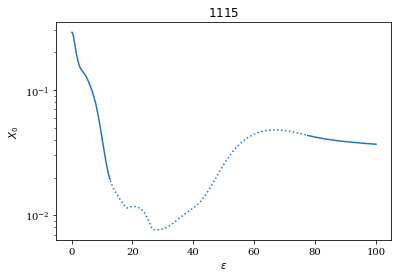

45.12
128 310 12 155 1119
127 124

 582.3414149809978


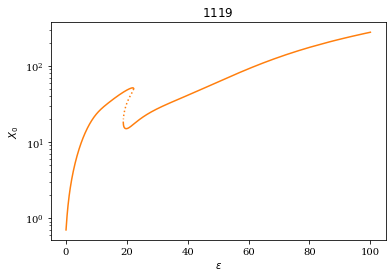

128 310 12 155 1124
128 125

 35.040441679011565


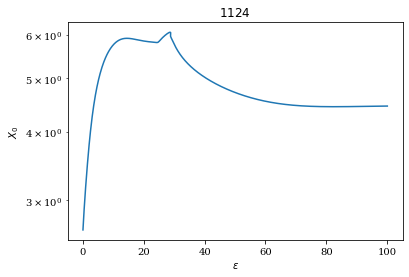

128 310 12 155 1129
124 121

 30.647909102000995


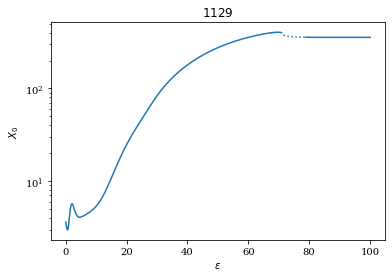

74.755
128 310 12 155 1146
128 125

 58.37335743999574


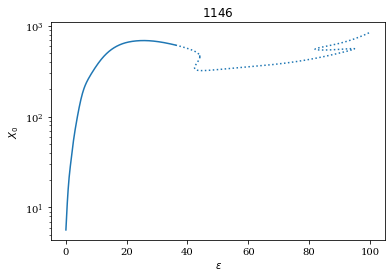

69.30591177435224
128 310 12 155 1148
125 122


In [ ]:
imp.reload(rmtchem)

filebase='data/seeds1'
f=open('seeds1','r')
seeds=np.array(f.readlines(),dtype=int)
f.close()

for seed in seeds:
    imp.reload(rmtchem)
    n=128
    nr=int(0.5*n*np.log(n))
    nd=int(0.1*n)
    na=int(0.5*nr)
    natoms=3
    print(n,nr,nd,na,seed)

    np.random.seed(seed)
    eta,nu,k,G,atoms=rmtchem.get_network(n,nr,na,natoms,False) 
    row,col=np.where(eta[::2]-nu[::2]!=0)
    data=(eta[::2]-nu[::2])[row,col]
    A=csr_matrix((data,(row,col)),shape=(2*nr,n),dtype=int)
    adj=A.T.dot(A)
    g=nx.convert_matrix.from_scipy_sparse_array(adj)
    lcc=np.array(list(max(nx.connected_components(g), key=len)))
    n=len(lcc)
    eta=eta[:,lcc]
    nu=nu[:,lcc]
    G=G[lcc]
    d0=1e6
    d1min=0
    d1max=100
    XD1,XD2,inds=rmtchem.get_drive(eta,nu,k,G,d0,nd)
    m=(eta[::2]-nu[::2]).T.dot(nu[::2]-eta[::2])
    print(len(lcc),np.linalg.matrix_rank(m))
    
    X0=np.exp(-G)
    start=timeit.default_timer()
    Xs,epsilons,evals,bif,dxs=rmtchem.pseudoarclength_log(X0, eta, nu, k, XD1, XD2, 0, 100, ds=1e-2,  dsmax=1e-1, output=0,stop=False,sn_detect=False,hopf_detect=False,cond_detect=False)


    stop=timeit.default_timer()
    print('\n',stop-start)

    i=np.where(XD1==0.)[0][0]
    inds1=np.where(np.max(np.real(evals),axis=1)<0)[0]
    inds2=np.where(np.max(np.real(evals),axis=1)>=0)[0]
    plt.yscale('log')
    for inds in np.split(inds1, np.where(np.diff(inds1) != 1)[0]+1):
        plt.plot(epsilons[inds],Xs[inds,i],color=colors[np.mod(i,len(colors))])
    for inds in np.split(inds2, np.where(np.diff(inds2) != 1)[0]+1):
        plt.plot(epsilons[inds],Xs[inds,i],ls=':',color=colors[np.mod(i,len(colors))])
    plt.xlabel('$\epsilon$')
    plt.ylabel('$X_0$')
    plt.title('$%i$'%(seed))
    plt.savefig(filebase+'/'+str(seed)+'.pdf')
    plt.show()

    unstables=[]
    for epsilon in np.arange(0,100,0.01):
        inds=np.where(np.abs(epsilons-epsilon)<1)
        if np.all(np.max(np.real(evals[inds]),axis=1)>0):
            unstables=unstables+[epsilon]
    if len(unstables)>0:
        if not os.path.exists(filebase+'/%i'%(seed)):
            os.mkdir(filebase+'/%i'%(seed))
        epsilon0=np.mean(unstables)
        print(epsilon0)
        np.save(filebase+'/%i/Xs'%(seed),Xs)
        np.save(filebase+'/%i/epsilons'%(seed),epsilons)
        np.save(filebase+'/%i/evals'%(seed),evals)

### Sweep of oscillating states

In [5]:
filebase='data/seeds1'
for seedstr in open(filebase+'/seeds','r'):
    seed=int(seedstr)
    Xs=np.load(filebase+'/'+str(seed)+'/Xs.npy')
    evals=np.load(filebase+'/'+str(seed)+'/evals.npy')
    epsilons=np.load(filebase+'/'+str(seed)+'/epsilons.npy')
    if(np.max(epsilons)>100):
        unstables=[]
        for epsilon in np.arange(0,100,0.01):
            inds=np.where(np.abs(epsilons-epsilon)<1)
            if np.all(np.max(np.real(evals[inds]),axis=1)>0):
                unstables=unstables+[epsilon]
        if len(unstables)>0 and not os.path.exists(filebase+'/'+str(seed)+'/Xts.npy'):
            print(seed)
            n=128
            nr=int(0.5*n*np.log(n))
            nd=int(0.1*n)
            na=int(0.5*nr)
            natoms=3

            np.random.seed(seed)
            eta,nu,k,G,atoms=rmtchem.get_network(n,nr,na,natoms,False) 
            row,col=np.where(eta[::2]-nu[::2]!=0)
            data=(eta[::2]-nu[::2])[row,col]
            A=csr_matrix((data,(row,col)),shape=(2*nr,n),dtype=int)
            adj=A.T.dot(A)
            g=nx.convert_matrix.from_scipy_sparse_array(adj)
            lcc=np.array(list(max(nx.connected_components(g), key=len)))
            n=len(lcc)
            eta=eta[:,lcc]
            nu=nu[:,lcc]
            G=G[lcc]
            d0=1e6
            d1min=0
            d1max=100
            XD1,XD2,inds=rmtchem.get_drive(eta,nu,k,G,d0,nd)
            m=(eta[::2]-nu[::2]).T.dot(nu[::2]-eta[::2])

            epsilon=np.mean(unstables)
            m0=np.argmin(np.abs(epsilons-epsilon))
            np.random.seed(1)
            X0=Xs[m0]
            ev,evec=np.linalg.eig(rmtchem.jac(0,X0,eta,nu,k,(1+epsilon)*XD1, XD2))
            tscale=2*np.pi/np.abs(np.real(ev[np.argmin(np.abs(np.real(ev)))]))
            dt=100/np.max(np.abs(rmtchem.func(0,X0,eta,nu,k,(1+epsilon)*XD1, XD2)/X0))

            start=timeit.default_timer()
            try:
                null_fd = os.open(os.devnull, os.O_RDWR)
                os.dup2(null_fd, 1) #trick to suppress stdout from lsoda fortran calls
                ts,Xts,success,m1,state=rmtchem.integrate(X0,eta,nu,k,(1+epsilon)*XD1,XD2,1e4*tscale,dt,output=True,maxcycles=25,maxsteps=1e5)
            except Exception as e:
                success=False
            stop=timeit.default_timer()
            print(stop-start,flush=True)
            np.save(filebase+'/'+str(seed)+'/Xts.npy',Xts)
            if success and state==1:
                plt.yscale('log')
                plt.plot(ts/tscale,np.transpose(Xts)/X0)
                plt.show()
                plt.plot(Xts[0,m1:],Xts[1,m1:],linewidth=0.1)
                plt.savefig(filebase+'/'+str(seed)+'/cycle.pdf')
                plt.show()
            elif success and state==0:
                plt.yscale('log')
                plt.plot(ts/tscale,np.transpose(Xts)/X0)
                plt.savefig(filebase+'/'+str(seed)+'/steady.pdf')
                plt.show()
            else:
                print('problem!')


### Empirical reaction network stoichiometry

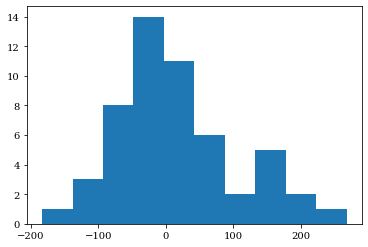

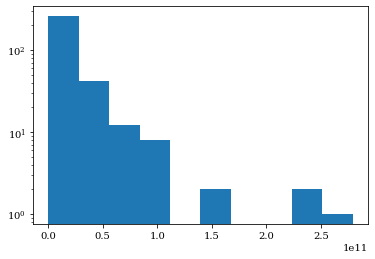

In [82]:
gas=ct.Solution('gri30.cti')
plt.hist(gas.standard_gibbs_RT)
plt.show()
plt.yscale('log')
plt.hist(gas.forward_rate_constants)
plt.show()

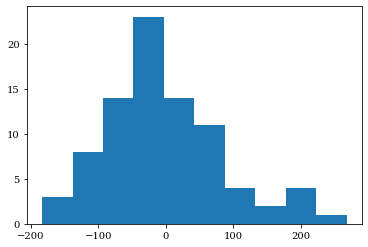

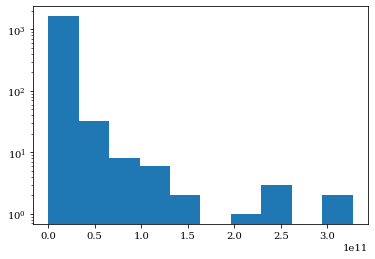

In [95]:
gas=ct.Solution('data/pyrolysis.cti')
plt.hist(gas.standard_gibbs_RT)
plt.show()
indices=np.where(gas.forward_rate_constants<1e15)[0]
plt.yscale('log')
plt.hist(gas.forward_rate_constants[indices])
plt.show()